<a href="https://colab.research.google.com/github/saeedmoazami/shared_point/blob/main/ame_508_project_ipnyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Saeed Moazami
# email: saeedmoa@usc.edu
# USC ID: 5369746907

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential

In [3]:
activation_fcn = tf.math.sin

In [4]:
def build_model(input_dim=3, output_dim=1, width=20, depth=10, activation='sin', reg_param=1.0e-7):

  model = tf.keras.Sequential()
  model.add(tf.keras.Input(shape=(input_dim,)))
  for _layer  in range(depth):
    model.add(tf.keras.layers.Dense(units = output_dim if _layer==(depth-1) else width,
                                    activation = None  if _layer==(depth-1) else activation_fcn,
                                    # kernel_initializer = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.),
                                    # bias_initializer   = tf.keras.initializers.RandomUniform(minval=-1., maxval=1.),
                                    kernel_regularizer = tf.keras.regularizers.l2(l2=reg_param),
                                    bias_regularizer   = tf.keras.regularizers.l2(l2=reg_param)))
  model.compile()
  return model

In [10]:
data_type = tf.float32

N = 16

interior = []
boundary_1 = []
boundary_2 = []
initial_condition = []

# input_np = np.zeros((N*N*N, 3))
for k in range(N):
  for j in range(N):
    for i in range(N):
      interior += [i/(N-1), j/(N-1), k/(N-1)]
      if (i/(N-1) == 0) or (i/(N-1) == 1.) or (j/(N-1) == 0):
        boundary_1 += [i/(N-1), j/(N-1), k/(N-1)]
      elif (j/(N-1) == 1):
        boundary_2 += [i/(N-1), j/(N-1), k/(N-1)]
      elif k/(N-1) == 0:
        initial_condition += [i/(N-1), j/(N-1), k/(N-1)]

      # if (j/(N-1) == 1) and ((i/(N-1) != 0) and (i/(N-1) != 1.) and (j/(N-1) != 0)):
      #   boundary_2 += [i/(N-1), j/(N-1), k/(N-1)]
      # if k/(N-1) == 0):
      #   initial_condition += [i/(N-1), j/(N-1), k/(N-1)]


interior = np.reshape(interior, (N**3,3))
boundary_1 = np.reshape(boundary_1, (-1,3))
boundary_2 = np.reshape(boundary_2, (-1,3))
initial_condition = np.reshape(initial_condition, (-1,3))

interior_length = len(interior)
boundary_1_length = len(boundary_1)
boundary_2_length = len(boundary_2)
initial_condition_length = len(initial_condition)


print(np.shape(interior), interior_length)
print(np.shape(boundary_1), boundary_1_length)
print(np.shape(boundary_2), boundary_2_length)
print(np.shape(initial_condition), initial_condition_length)
# for i in range(1000):
  # print(input[i])
interior_variable = tf.Variable(interior, dtype=data_type)
interior_constant = tf.constant(interior, dtype=data_type)
boundary_1_constant = tf.constant(boundary_1, dtype=data_type)
boundary_2_constant = tf.constant(boundary_2, dtype=data_type)
initial_condition_constant = tf.constant(initial_condition, dtype=data_type)

# print(interior_variable)
# print(boundary_1_constant)
# print(boundary_2_constant)

(4096, 3) 4096
(736, 3) 736
(224, 3) 224
(196, 3) 196


In [11]:
# interior

(736, 3)


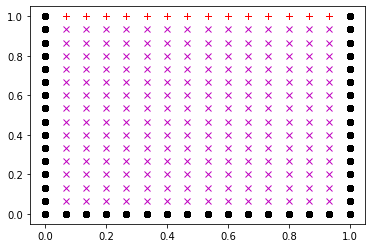

In [12]:
print(np.shape(boundary_1))
# print(boundary[:])

# for i in range(len(interior)):
#   # print(boundary[i][0:2])
#   plt.plot(interior[i][0],interior[i][1], 'bd')

  
for i in range(len(boundary_1)):
  # print(boundary[i][0:2])
  plt.plot(boundary_1[i][0],boundary_1[i][1], 'ko')

for i in range(len(boundary_2)):
  # print(boundary[i][0:2])
  plt.plot(boundary_2[i][0],boundary_2[i][1], 'r+')

for i in range(len(initial_condition)):
  # print(boundary[i][0:2])
  plt.plot(initial_condition[i][0],initial_condition[i][1], 'mx')

plt.show()

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# n = 100

# # For each set of style and range settings, plot n random points in the box
# # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].


# for i in range(len(boundary_1)):
#     ax.scatter3D(boundary_1[i][0],boundary_1[i][1],boundary_1[i][2], color = 'r', marker='o')
# for i in range(len(boundary_2)):
#     ax.scatter3D(boundary_2[i][0],boundary_2[i][1],boundary_2[i][2], color = 'k', marker='d')
# # for i in range(len(interior)):
# #     ax.scatter(interior[i][0],interior[i][1],interior[i][2], color = 'b',marker='.')
# for i in range(len(initial_condition)):
#     ax.scatter3D(initial_condition[i][0],initial_condition[i][1],initial_condition[i][2], color = 'm', marker='+')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# plt.show()


In [14]:
def custom_loss(model, nn_input, thermal_diffusivity, lambda_b, lambda_init):
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      u = model(nn_input, training=True)    
    du_dx = tape2.gradient(u, nn_input)
  du2_dx2 = tape1.gradient(du_dx, nn_input)

  lu = thermal_diffusivity * (du2_dx2[:,0] + du2_dx2[:,1]) - du_dx[:,2]

  b_1_loss = (1/boundary_1_length) * tf.math.reduce_sum(tf.math.square(model(boundary_1_constant)))

  b_2_loss = (1/boundary_2_length) * tf.math.reduce_sum(tf.math.square(1. - model(boundary_2_constant)))

  initial_loss = (1/initial_condition_length) * tf.math.reduce_sum(tf.math.square(1. - model(initial_condition_constant)))



  boundary_loss = b_1_loss + b_2_loss

  
  int_loss = (1.0/interior_length) * tf.math.reduce_sum(tf.math.square(lu))


  loss_value = int_loss + (lambda_b * boundary_loss) + (lambda_init * initial_loss)

  reg_loss = tf.reshape(tf.reduce_sum(model.losses), shape = loss_value.shape)
  
  total_loss = loss_value + reg_loss
  # print("done")
  return total_loss, loss_value, int_loss, boundary_loss, initial_loss


  # history_set, result_set, _ = train(nn_input = nn_input, thermal_diffusivity = thermal_diffusivity,
  #                                    epochs = total_epochs,
  #                                    total_trials = 1,
  #                                    lambda_b = 10,
  #                                    verbose = True,
  #                                    print_inc = 1000)
  

In [15]:
save_inc = 200

In [16]:
def train(nn_input, thermal_diffusivity, epochs, lambda_b, lambda_init, 
          # history_set, result_set,
          total_trials = 1, verbose = True, print_inc = 500):

  # history_set = np.zeros((total_trials, epochs, 3)) #for each parameter, trial, epoch, total, interior, and boundary loss
  # result_set  = np.zeros((total_trials, N))         #for each parameter, trial, final results on collocation points
  best_loss = np.inf
  early_stop_counter = 0

  for _trial in range(total_trials):
    best_loss = np.inf
    early_stop_counter = 0

    print("Trial no:", _trial+1,' creading model ....................................................................................')
    tf.keras.backend.clear_session()
    optimizer = tf.keras.optimizers.Adam(learning_rate=3.0e-4)
    model=build_model()
    
    for iter in range(epochs):
      with tf.GradientTape() as main_tape:

        total_loss, loss_value, int_loss, boundary_loss, initial_loss = custom_loss(model, nn_input, thermal_diffusivity, lambda_b, lambda_init) 

      # history_set [_trial, iter, 0] = loss_value.numpy()
      # history_set [_trial, iter, 1] = int_loss.numpy()
      # history_set [_trial, iter, 2] = boundary_loss.numpy()

      grads_main = main_tape.gradient(total_loss, model.trainable_weights)

      optimizer.apply_gradients(zip(grads_main, model.trainable_weights))

      if verbose and (iter ==0 or ((iter+1) % print_inc) ==0 or iter == (epochs - 1)):
        print("loss values, iteration: {}/{}::: total: {:.6f} \t (interior, boundary, initial): {:.6f} {:.6f} {:.6f}".format(iter+1, epochs,
              loss_value.numpy().squeeze(), int_loss.numpy().squeeze(), boundary_loss.numpy().squeeze(), initial_loss.numpy().squeeze()))
        
      # print(best_loss)
      # trial_final_prediction = model(interior_constant).numpy().squeeze()
      if loss_value.numpy().squeeze() < best_loss:
        # print("loss Decreased")
        early_stop_counter = 0
        best_loss = loss_value.numpy().squeeze()
        if iter % save_inc == 0:
          print("savig model", iter, best_loss)
          model.save('./'+'best_model.h5')

      else:
        # print("loss increased", early_stop_counter)
        early_stop_counter += 1
        if early_stop_counter == 50:
          print("early stopping reached, best model will be returned")
          model = tf.keras.models.load_model('./'+'best_model.h5', custom_objects={'sin': tf.math.sin})
          return model
    

        
    print(model)
    return model
    # result_set[_trial] = trial_final_prediction
  # return history_set, result_set, model


In [17]:
# model.compiled_metrics = None

lambda_b = (interior_length/(boundary_1_length + boundary_1_length))
lambda_init = interior_length / initial_condition_length

print(lambda_b, lambda_init)

2.782608695652174 20.897959183673468


In [18]:
thermal_diffusivity = 10
total_epochs = 10000
history_all = []
result_all  = []

# history_set, result_set, _ = 
model = train(nn_input = interior_variable, thermal_diffusivity = thermal_diffusivity, epochs = total_epochs, total_trials = 1,
              lambda_b = 10, lambda_init = 20, verbose = True, print_inc = 500)
# history_all += [history_set]
# result_all  += [result_set]

# result_all  = np.array(result_all)
# history_all = np.array(history_all)

Trial no: 1  creading model ....................................................................................
loss values, iteration: 1/10000::: total: 27.953474 	 (interior, boundary, initial): 1.228890 0.758597 0.956931
savig model 0 27.953474
savig model 200 3.947205
savig model 400 3.7293375
loss values, iteration: 500/10000::: total: 3.604859 	 (interior, boundary, initial): 0.077670 0.309111 0.021804
savig model 600 3.4729836
savig model 800 3.1331782
loss values, iteration: 1000/10000::: total: 2.246790 	 (interior, boundary, initial): 0.171450 0.182361 0.012586
savig model 1000 2.2413058
savig model 1400 1.7839912
loss values, iteration: 1500/10000::: total: 1.746524 	 (interior, boundary, initial): 0.087467 0.140251 0.012827
savig model 1600 1.709084
savig model 1800 1.6558181
loss values, iteration: 2000/10000::: total: 1.615952 	 (interior, boundary, initial): 0.046599 0.131317 0.012809
savig model 2200 1.5855486
savig model 2400 1.5618002
loss values, iteration: 2500/100

(16, 16, 16)


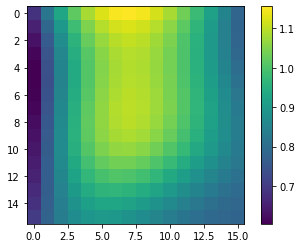

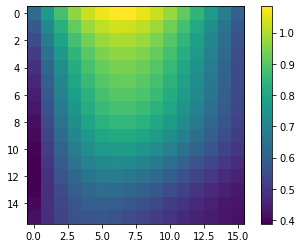

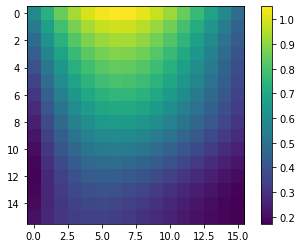

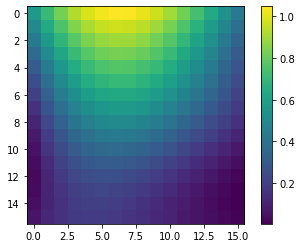

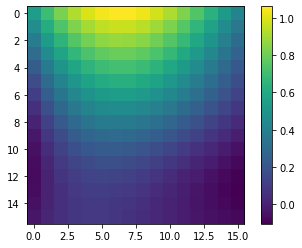

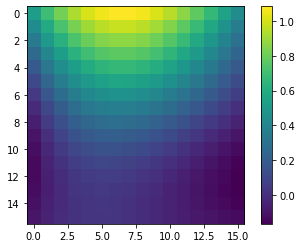

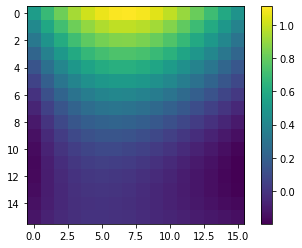

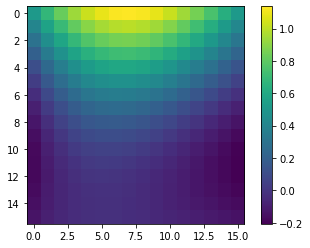

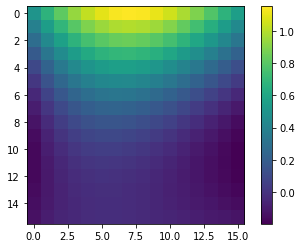

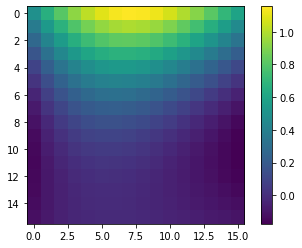

In [23]:
model = tf.keras.models.load_model('./'+'best_model.h5', custom_objects={'sin': tf.math.sin})

# interior_constant_flip = np.copy(interior)

# interior_constant_flip[:, [2, 0]] = interior[:, [0, 2]]
# interior_constant_flip[:, [1, 0]] = interior_constant_flip[:, [0, 1]]

trial_final_prediction = model(interior).numpy().squeeze()

results = np.reshape(trial_final_prediction, (N,N,N))
print(np.shape(results))
for i in range(10):
  contour = plt.imshow(np.flip(results[i,...], axis = 0))
  plt.colorbar(contour)

  plt.show()

(20, 20, 20)


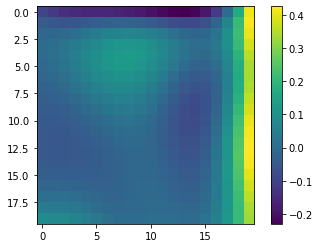

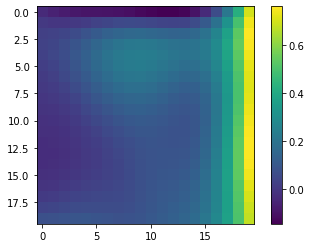

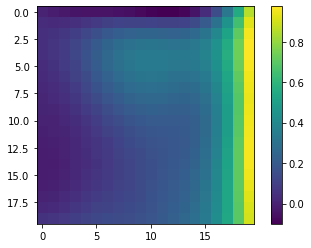

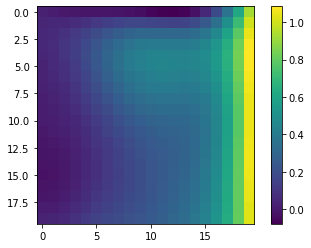

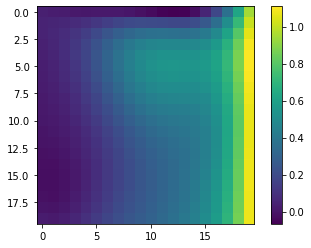

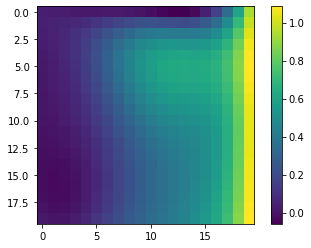

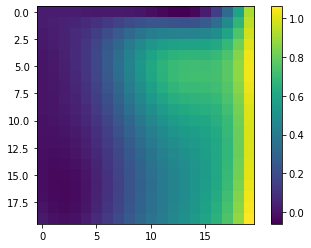

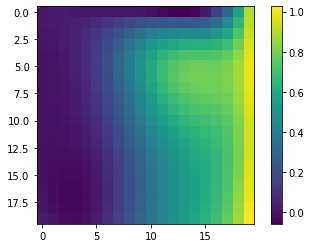

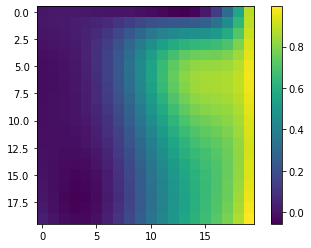

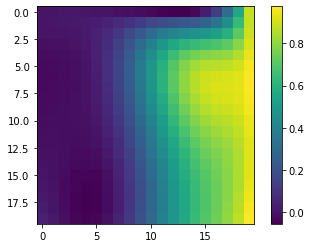

In [ ]:
# Retrieving the best model

total_params = len(pes)
best_hist   = np.zeros((total_params, total_epochs, 3))
best_reults = np.zeros((total_params, N))

best_model_index = np.argmin(history_all[:, :, -1, 0], axis = 1)
print("best trial model indices", best_model_index)

for i in range(total_params):
  best_hist[i]   = history_all[i, best_model_index[i], :, :].squeeze()
  best_reults[i] = result_all[i, best_model_index[i], :]

best trial model indices [1 2 2 0]


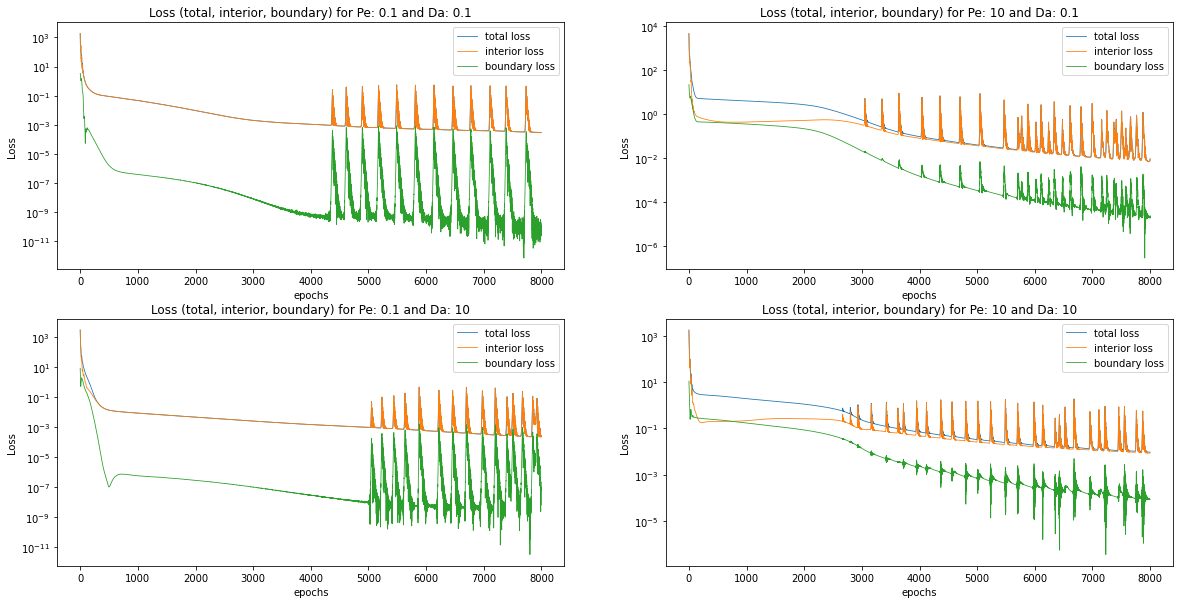

In [ ]:
fig1 = plt.figure(figsize=(20, 10))
fig1.clf()

for param in range(len(pes)):
  ax0 = plt.subplot(2, len(pes)//2, param+1)
  for i in range(3):
    ax0.semilogy(best_hist[param, :, i], '-', linewidth = 0.8)
  ax0.legend(["total loss", "interior loss", "boundary loss"])
  ax0.set_title("Loss (total, interior, boundary) for Pe: {} and Da: {}".format(pes[param], Das[param]))
  ax0.set_xlabel('epochs')
  ax0.set_ylabel('Loss')
plt.show()

As it can be observed, the order of magnitude for the total loss for pe = 10 is roughly -2, and for pe = 0.1 is -4, i.e., 100 times lower.
This is an indicator that the results for pe=10 are less accurate.


In [ ]:
def retrieve_benchmark():
  try:
    # !ls -la
    # !rm -rf shared_point
    !git clone "https://github.com/saeedmoazami/shared_point"
    !ls shared_point
    # !ls -la
    pe_01_da_01 = np.load("./shared_point/diffusion-advection-reaction_pe_0.1_da_0.1.npy")
    pe_10_da_01 = np.load("./shared_point/diffusion-advection-reaction_pe_10_da_0.1.npy")
    pe_01_da_10 = np.load("./shared_point/diffusion-advection-reaction_pe_0.1_da_10.npy")
    pe_10_da_10 = np.load("./shared_point/diffusion-advection-reaction_pe_10_da_10.npy")
    print("benchmark data downloaded")
    return pe_01_da_01, pe_10_da_01, pe_01_da_10, pe_10_da_10
  except:
    print("Benchmark data could not be retrieved, trying to load locally .....")
    try:
      pe_01_da_01 = np.load("diffusion-advection-reaction_pe_0.1_da_0.1.npy")
      pe_10_da_01 = np.load("diffusion-advection-reaction_pe_10_da_0.1.npy")
      pe_01_da_10 = np.load("diffusion-advection-reaction_pe_0.1_da_10.npy")
      pe_10_da_10 = np.load("diffusion-advection-reaction_pe_10_da_10.npy")
      print("benchmark data loaded locally")
      return pe_01_da_01, pe_10_da_01, pe_01_da_10, pe_10_da_10
    except:
      print("Benchmark data could not be retrieved")
      return False

pe_01_da_01, pe_10_da_01, pe_01_da_10, pe_10_da_10 = retrieve_benchmark()
benchmark = [pe_01_da_01[1].T, pe_10_da_01[1].T, pe_01_da_10[1].T, pe_10_da_10[1].T, pe_01_da_01[0].T]
benchmark_2 = [pe_10_da_01[1].T, pe_10_da_10[1].T, pe_01_da_01[0].T]

Cloning into 'shared_point'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 7), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.
diffusion-advection-reaction_pe_0.1_da_0.1.npy
diffusion-advection-reaction_pe_0.1_da_10.npy
diffusion-advection-reaction_pe_10_da_0.1.npy
diffusion-advection-reaction_pe_10_da_10.npy
benchmark data downloaded


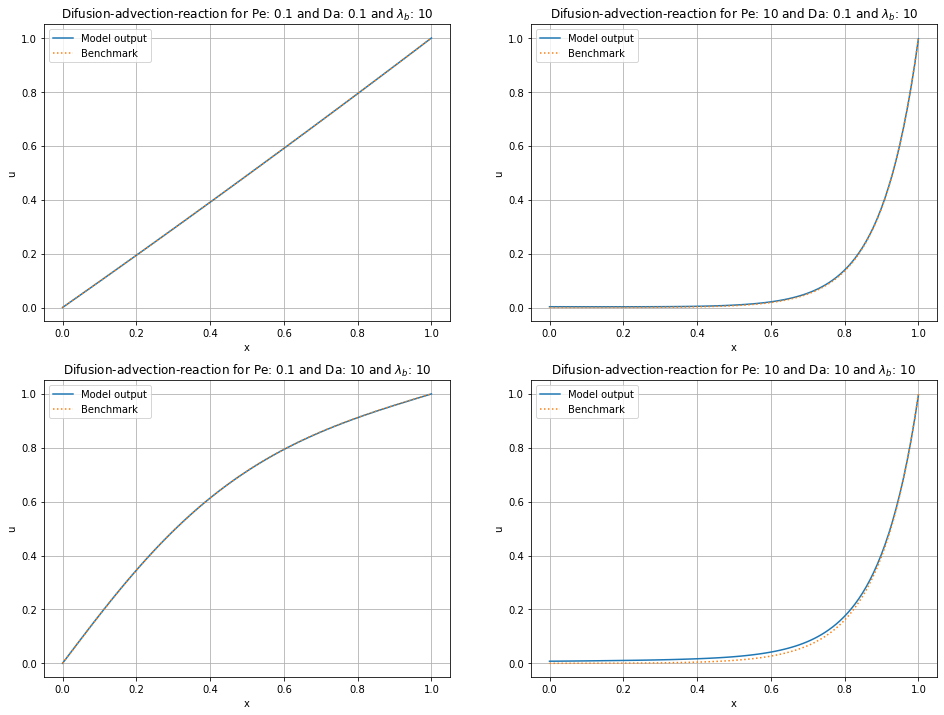

In [ ]:
fig1 = plt.figure(figsize=(16, 12))
fig1.clf()

for param in range(len(pes)):
  ax1 = plt.subplot(2, len(pes)//2, param+1)
  ax1.plot(x.numpy(), best_reults[param, :])
  try:
    ax1.plot(benchmark[-1], benchmark[param], ':')
  except:
    print("ERROR LOCATING BENCHMARK DATA ......")
    print("please put it in benchmark = [pe_01_da_01[1].T, pe_10_da_01[1].T, pe_01_da_10[1].T, pe_10_da_10[1].T, pe_01_da_01[0].T] format")
  # ax1.plot(result_set[param, 0, :])
  ax1.legend(["Model output", "Benchmark"])
  ax1.set_title("Difusion-advection-reaction for Pe: {} and Da: {} and $\lambda_b$: 10".format(pes[param], Das[param]))
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.grid('on')
plt.show()


As can be seen, the results for pe = 0.1 are almost a perfect fit, while for pe = 10, they deviate slightly. 

In the following, the algorithm will use $\lambda_b=1000$ for training

In [ ]:
total_epochs = 8000

pes_2 = [10.0, 10.0]
Das_2 = [0.1, 10.0]

history_all_2 = []
result_all_2  = []

for parameters in range(len(pes_2)):
  pe, Da = pes_2[parameters], Das_2[parameters]
  print("\nSolving for Peclet no.: {},\t Damkohler no.: {}".format(pe, Da))

  history_set_2, result_set_2, _ = train(x = x, pe = pe, Da = Da, epochs = total_epochs, total_trials = 3, lambda_b = 1000, verbose = True, print_inc = 1000)
  history_all_2 += [history_set_2]
  result_all_2  += [result_set_2]

result_all_2  = np.array(result_all_2)
history_all_2 = np.array(history_all_2)


Solving for Peclet no.: 10.0,	 Damkohler no.: 0.1
Trial no: 1  creading model ....................................................................................
loss values, iteration: 1/8000::: total: 20931.322266 	 (interior, boundary): 7776.861816 13.154461
loss values, iteration: 1000/8000::: total: 9.180719 	 (interior, boundary): 8.578730 0.000602
loss values, iteration: 2000/8000::: total: 0.798749 	 (interior, boundary): 0.786062 0.000013
loss values, iteration: 3000/8000::: total: 0.243237 	 (interior, boundary): 0.241566 0.000002
loss values, iteration: 4000/8000::: total: 0.118445 	 (interior, boundary): 0.117977 0.000000
loss values, iteration: 5000/8000::: total: 0.072082 	 (interior, boundary): 0.069233 0.000003
loss values, iteration: 6000/8000::: total: 0.159977 	 (interior, boundary): 0.129153 0.000031
loss values, iteration: 7000/8000::: total: 0.111254 	 (interior, boundary): 0.061636 0.000050
loss values, iteration: 8000/8000::: total: 0.027452 	 (interior, bound

In [ ]:
# Retrieving the best model

total_params_2 = len(pes_2)
best_hist_2   = np.zeros((total_params_2, total_epochs, 3))
best_reults_2 = np.zeros((total_params_2, N))

best_model_index_2 = np.argmin(history_all_2[:, :, -1, 0], axis = 1)
print("best trial model indices", best_model_index_2)

for i in range(total_params_2):
  best_hist_2[i]   = history_all_2[i, best_model_index_2[i], :, :].squeeze()
  best_reults_2[i] = result_all_2[i, best_model_index_2[i], :]

best trial model indices [0 0]


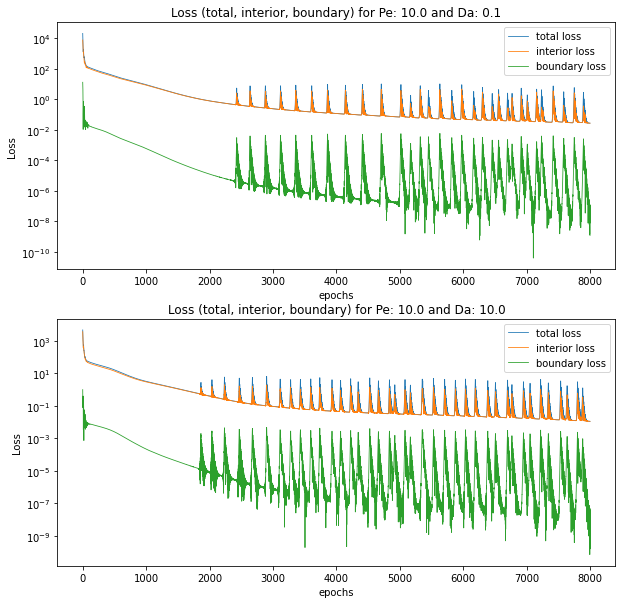

In [ ]:
fig1 = plt.figure(figsize=(10, 10))
fig1.clf()

for param in range(len(pes_2)):
  ax0 = plt.subplot(2, len(pes_2)//2, param+1)
  for i in range(3):
    ax0.semilogy(best_hist_2[param, :, i], '-', linewidth = 0.8)
  ax0.legend(["total loss", "interior loss", "boundary loss"])
  ax0.set_title("Loss (total, interior, boundary) for Pe: {} and Da: {}".format(pes_2[param], Das_2[param]))
  ax0.set_xlabel('epochs')
  ax0.set_ylabel('Loss')
plt.show()

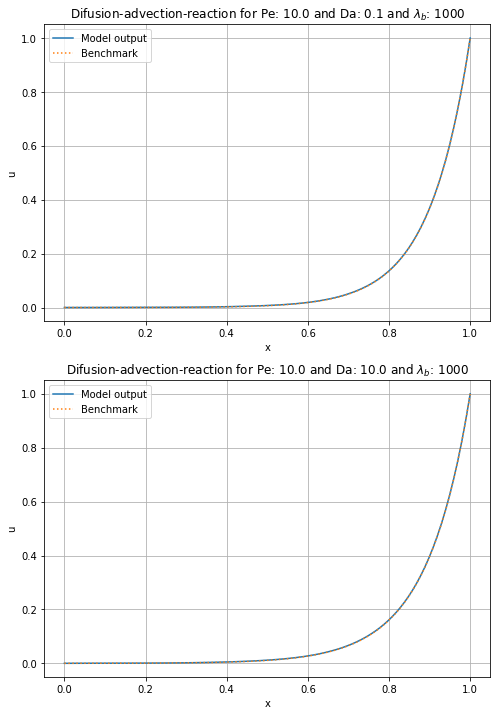

In [ ]:
fig1 = plt.figure(figsize=(8, 12))
fig1.clf()

for param in range(len(pes_2)):
  ax1 = plt.subplot(2, len(pes_2)//2, param+1)
  ax1.plot(x.numpy(), best_reults_2[param, :])
  try:
    ax1.plot(benchmark_2[-1], benchmark_2[param], ':')
  except:
    print("ERROR LOCATING BENCHMARK DATA ......")
    print("please put it in benchmark = [pe_01_da_01[1].T, pe_10_da_01[1].T, pe_01_da_10[1].T, pe_10_da_10[1].T, pe_01_da_01[0].T] format")
  # ax1.plot(result_set[param, 0, :])
  ax1.legend(["Model output", "Benchmark"])
  ax1.set_title("Difusion-advection-reaction for Pe: {} and Da: {} and $\lambda_b$: 1000".format(pes_2[param], Das_2[param]))
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.grid('on')
plt.show()


The results for parameter sets with pe=10 yield better match using $\lambda_b=1000$

One should note that the total loss values can not be directly compared between cases with different $\lambda_b$ as it changes the loss function.

However, a significant drop in loss values and a perfect match with the benchmark indicates a successful model training using the new $\lambda_b$

To improve the accuracy, one way would be to increase the number of collocation points.
Using different hyperparameters can result in different accuracies that need to be evaluated.

Using higher precision for numeric calculation such as NumPy or Tensorflow float64 also can be investigated.

However, the results seem to be accurate enough in the current setup.
